# Fully saturated TWFE の解釈

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices

figsize=(1.618*6, 1*6)

In [2]:
path = '../../data/processed/fully_saturated/homo.csv'
beta_df = pd.read_csv(path)
# path = '../../data/processed/fully_saturated/hetero.csv'
# hetero_beta_df = pd.read_csv(path)
path = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(path)
df = df.rename(columns={'island_names': '島名'})
path = '../../data/raw/yashiro_and_shodo.xlsx'
df_yashiro_shodo = pd.read_excel(path)


In [3]:
class FullySaturatedPlotter():
    def __init__(self, data=None, trace=None, beta_df=None):
        self.data = data
        self.trace = trace
        self.beta_df = beta_df

    def plot_treatment_effect(self, bridge_year, ax=None):
        beta_g = self.beta_df.query(f'bridge_year == {bridge_year}').sort_values('time_since_treatment')
        fig, ax = plt.subplots(figsize=figsize)
        sns.lineplot(data=beta_g, x='time_since_treatment', y='mean', color='black', marker='o', label='平均', ax=ax)
        ax.fill_between(
            x='time_since_treatment',
            y1='hdi_97.5%',
            y2='hdi_2.5%',
            data=beta_g,
            alpha=0.3,
            color='black',
            label='95%信用区間'
        )
        ax.axhline(0, color='black', ls=':')
        ax.axvline(0, color='black', ls=':')
        ax.set_title(f'介入: {bridge_year} 年')
        ax.set_xlabel('経過年数')
        ax.set_ylabel('係数')
        ax.legend()

    def plot_population(self, bridge_year, ax=None):
        df_g = self.data.query(f'bridge_year == {bridge_year}')
        print(df_g.island_ids.unique())
        fig, ax = plt.subplots(figsize=figsize)
        sns.lineplot(x='year', y='population', data=df_g, color='black', ax=ax)
        ax.axvline(0, color='black', ls=':')
        ax.set_title(f'介入: {bridge_year}')
        ax.set_xlabel('経過年数')
        ax.set_ylabel('人口')

    def plot_population_and_treatment_effect(self, bridge_year, fig_num=None):
        fig, ax = plt.subplots(2, 1, figsize=(10, 6))
        fig.suptitle(f'図{fig_num}: {bridge_year}年に開通した橋の介入効果', fontsize=16, y=0.93)
        # fig.subplots_adjust(hspace=0.4)
        # 人口変化率のプロット
        df_g = self.data.query(f'bridge_year == {bridge_year}')
        # num_obs = df_g.island_ids.nunique()
        sns.lineplot(
            x='year',
            y='pop_rate_of_change',
            data=df_g,
            color='black',
            marker='o',
            ax=ax[0],
            hue='島名',
            palette=['black'],
        )

        # 年平均のプロット
        year_df = pd.DataFrame()
        year_df['year_mean'] = self.data.groupby('year')['log_pop'].mean()
        min_year = df_g.year.min()
        year_df = year_df.query(f'year >= {min_year}')
        year_df['year_mean_diff'] = year_df.year_mean.diff()
        year_df.fillna(0, inplace=True)
        year_df['year_mean_cumsum'] = year_df['year_mean_diff'].cumsum()
        year_df['year_mean_change_rate'] = 100 * (np.exp(year_df['year_mean_cumsum']) - 1)
        sns.lineplot(data=year_df, x=year_df.index, y='year_mean_change_rate', ax=ax[0], color='black', marker='o', label='年平均', ls='--')
        # 装飾
        ax[0].axvline(bridge_year, color='black', ls=':', label='介入年')
        ax[0].set_title('')
        ax[0].set_ylabel('人口変化率 (%)')
        ax[0].set_xlabel('')
        ax[0].legend()

        # 係数のプロット
        beta_g = self.beta_df.query(f'bridge_year == {bridge_year}').sort_values('time_since_treatment')
        sns.lineplot(
            data=beta_g,
            x='time_since_treatment',
            y='mean',
            color='black',
            marker='o',
            # label='事後期待値',
            ax=ax[1]
        )
        ax[1].fill_between(
            x='time_since_treatment',
            y1='hdi_97.5%',
            y2='hdi_2.5%',
            data=beta_g,
            alpha=0.3,
            color='black',
            # label='95%信用区間'
        )
        ax[1].axhline(0, color='black', ls=':')
        ax[1].axvline(0, color='black', ls=':')
        ax[1].set_title('')
        ax[1].set_xlabel('経過年数')
        ax[1].set_ylabel('係数')
        # ax[1].legend()

        filepath = f'../../docs/figures/fully_saturated_twfe/{bridge_year}.png'
        fig.savefig(filepath, bbox_inches='tight')

In [4]:
beta_homo = FullySaturatedPlotter(data=df, beta_df=beta_df)

    time_since_treatment   mean
85                   -17  0.736
86                   -12  0.600
87                    -7  0.754
88                    -2 -0.371
89                     3 -0.532
90                     8 -0.476
91                    13 -0.019
92                    18 -0.459
93                    23 -0.307
94                    28 -0.425
95                    33  0.021


/tmp/ipykernel_84918/2226488067.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df['year_mean_diff'] = year_df.year_mean.diff()
/tmp/ipykernel_84918/2226488067.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df.fillna(0, inplace=True)
/tmp/ipykernel_84918/2226488067.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

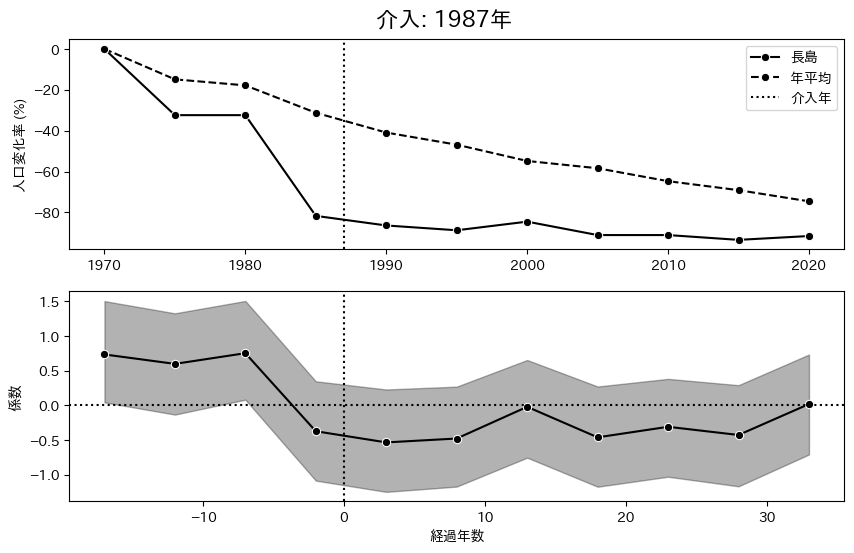

In [8]:
bridge_year = 1987

print(homo_beta_df.query(f'bridge_year == {bridge_year}')[['time_since_treatment', 'mean']])
beta_homo.plot_population_and_treatment_effect(bridge_year=bridge_year)

In [123]:
bridge_year_list = df['bridge_year'].unique()
bridge_year_list.sort()
bridge_year_list = bridge_year_list[1:-1]
len(bridge_year_list)

23

/tmp/ipykernel_2861/2226488067.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df['year_mean_diff'] = year_df.year_mean.diff()
/tmp/ipykernel_2861/2226488067.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df.fillna(0, inplace=True)
/tmp/ipykernel_2861/2226488067.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

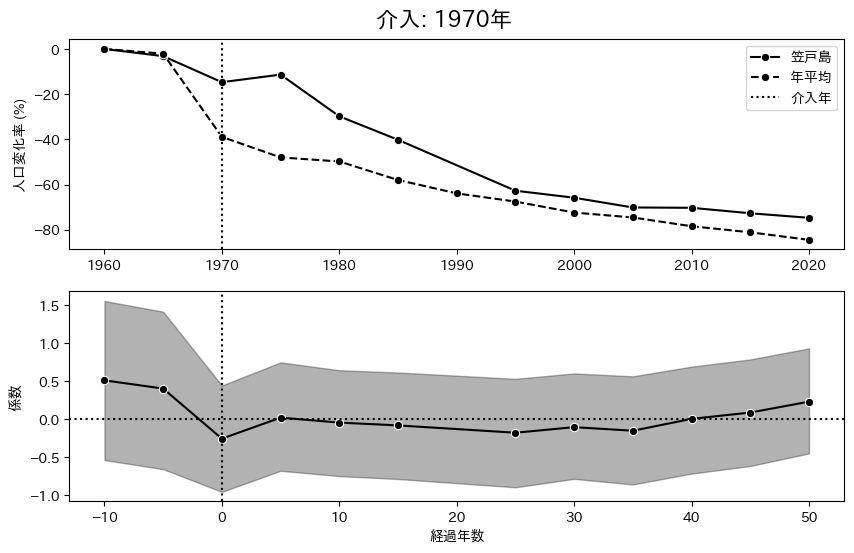

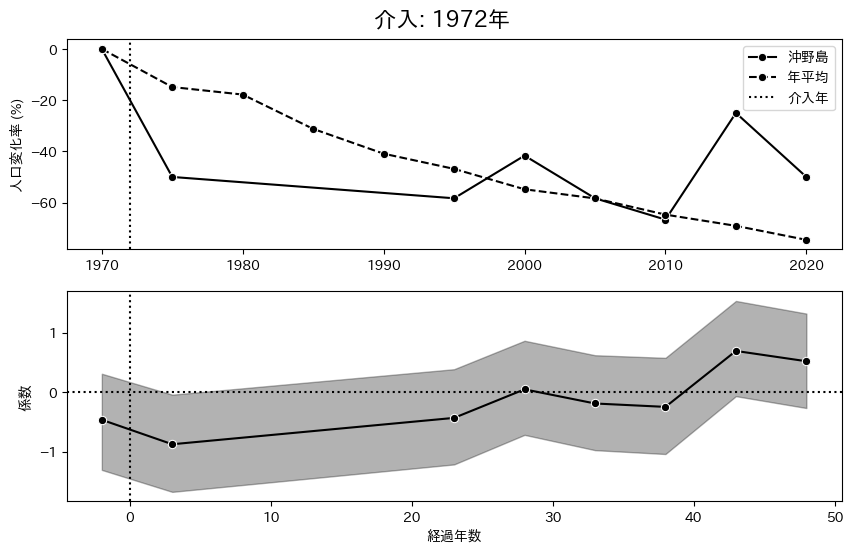

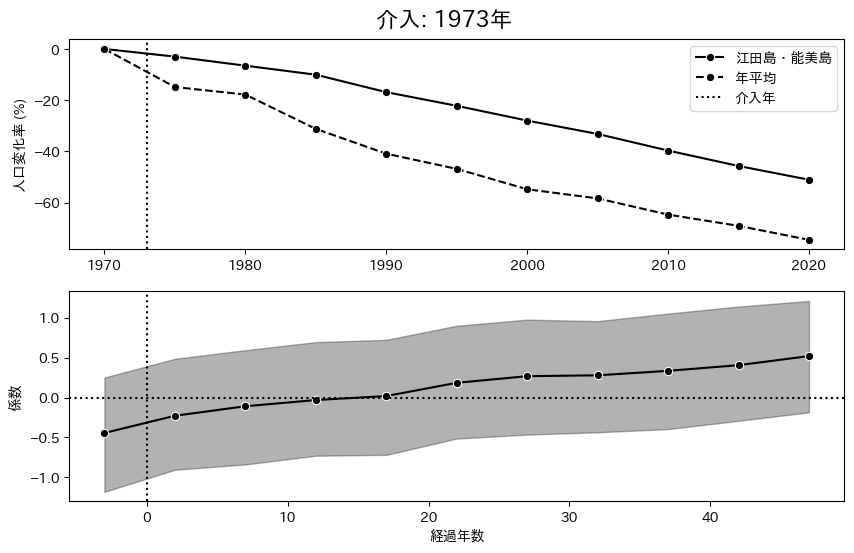

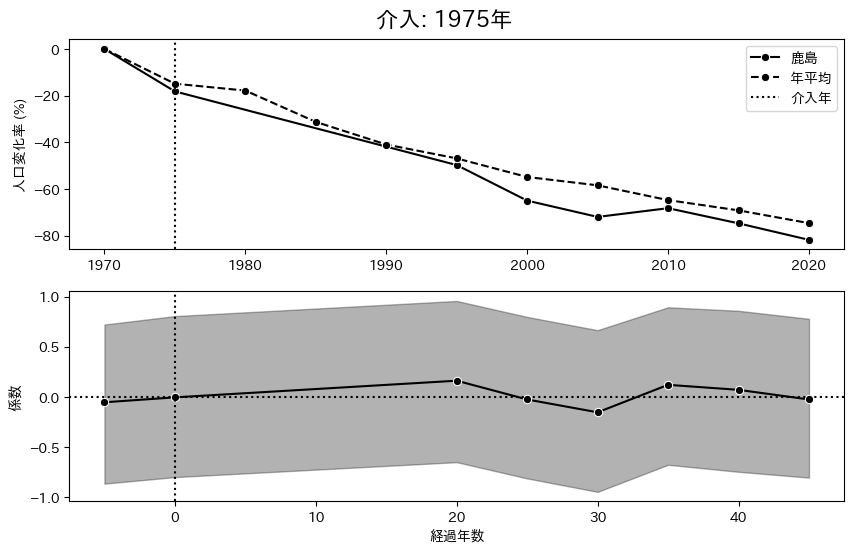

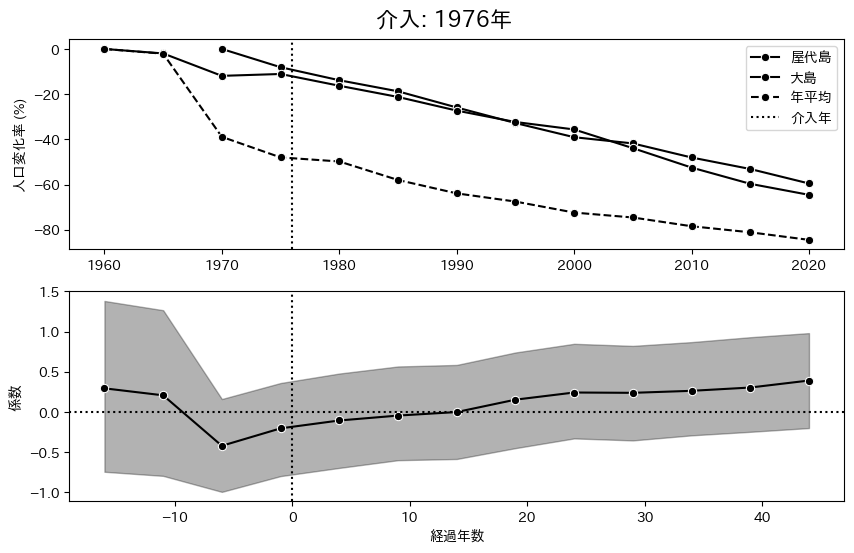

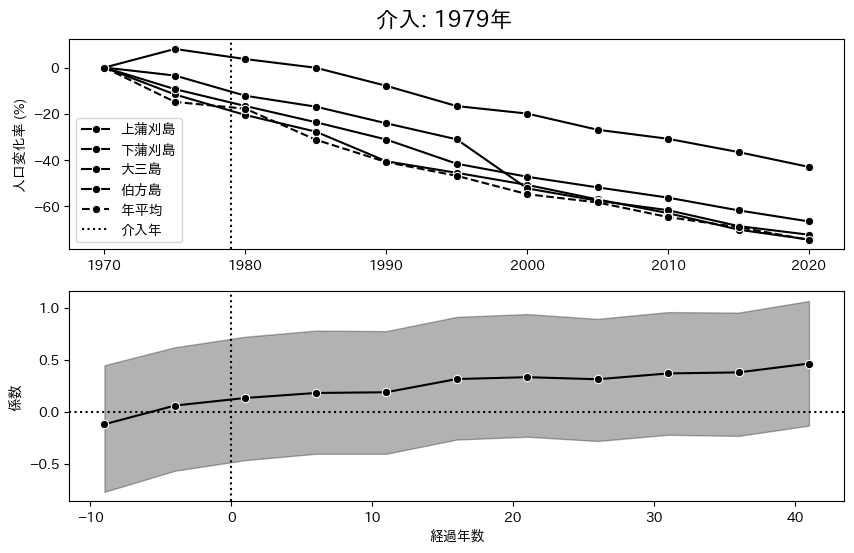

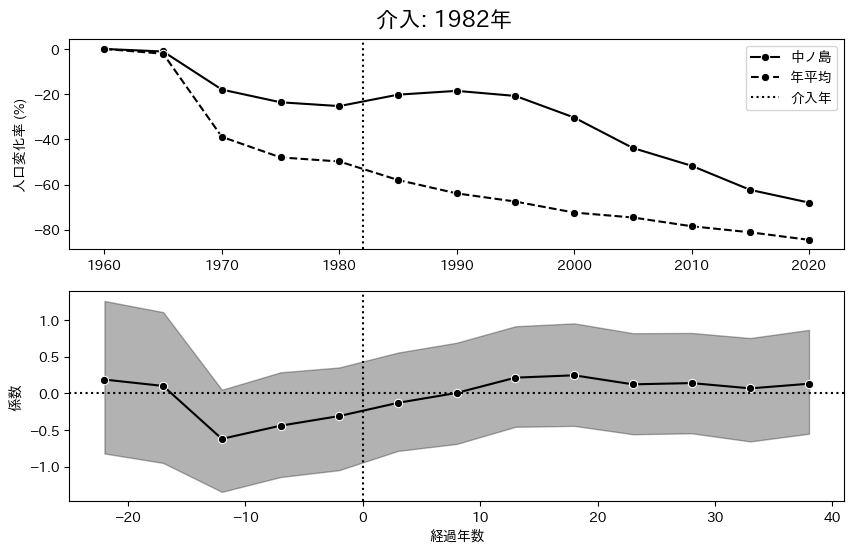

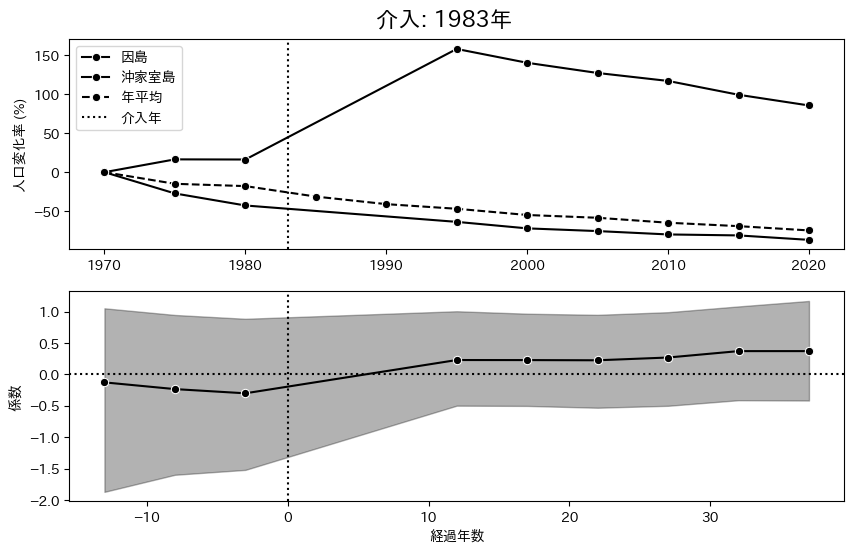

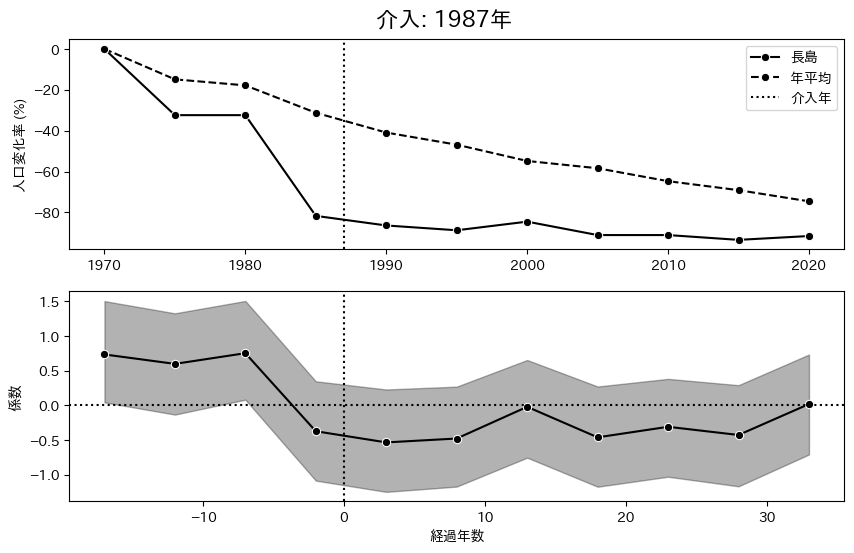

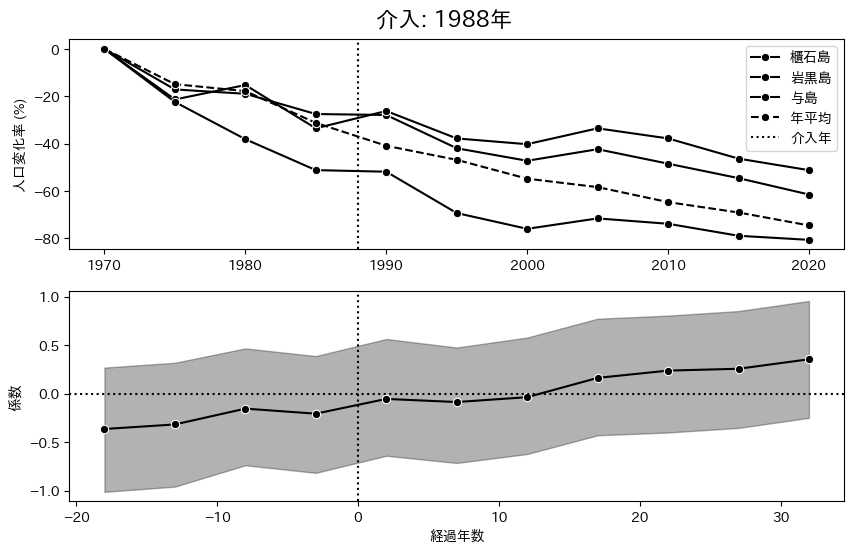

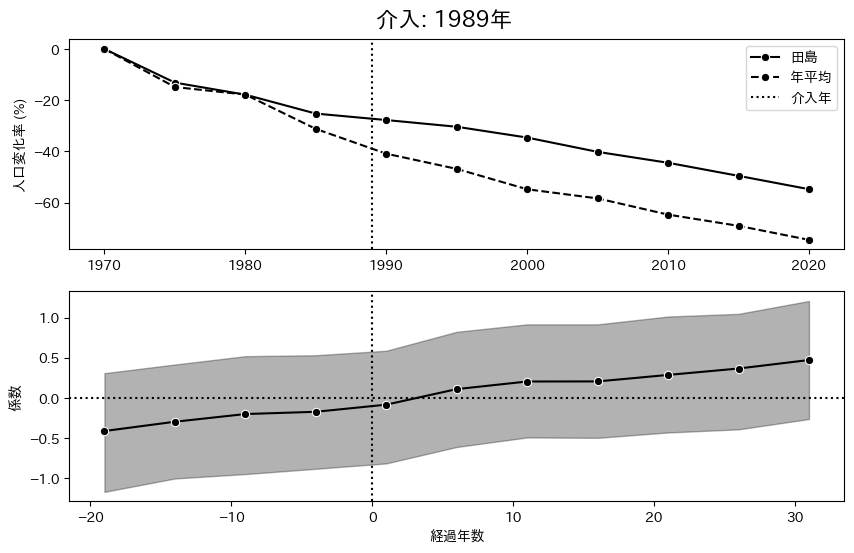

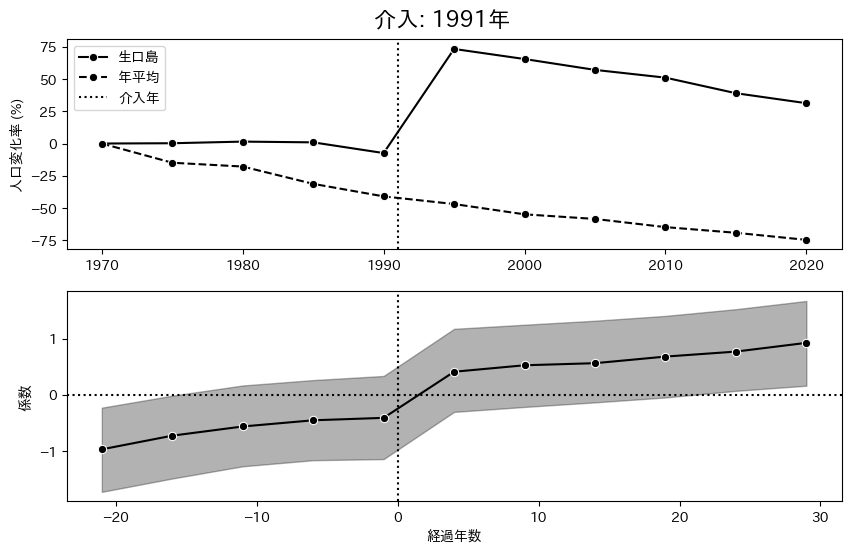

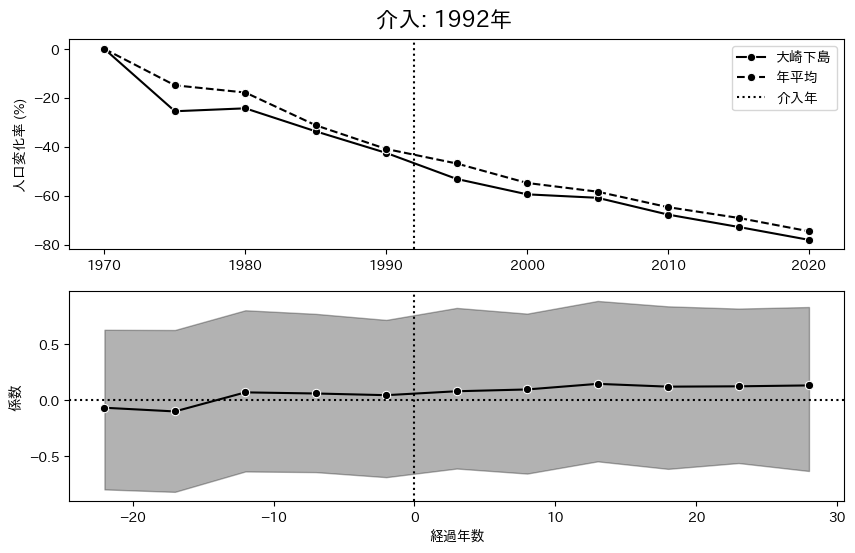

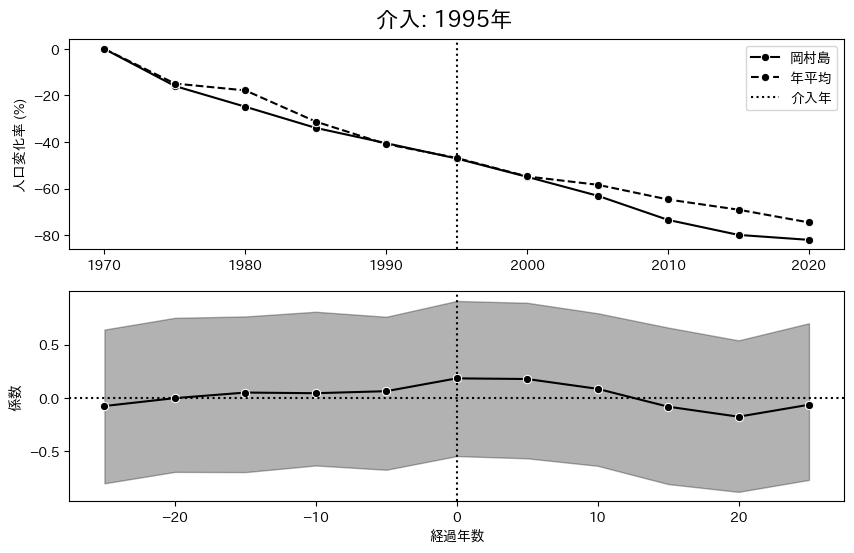

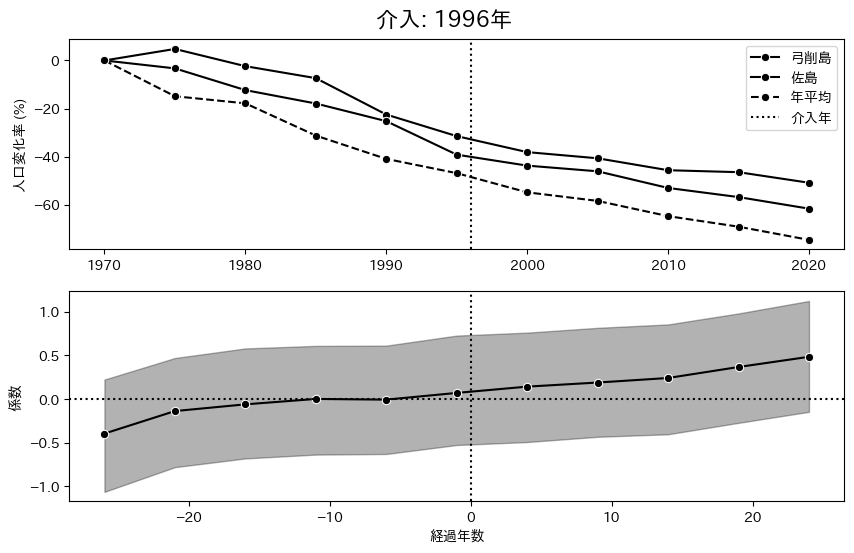

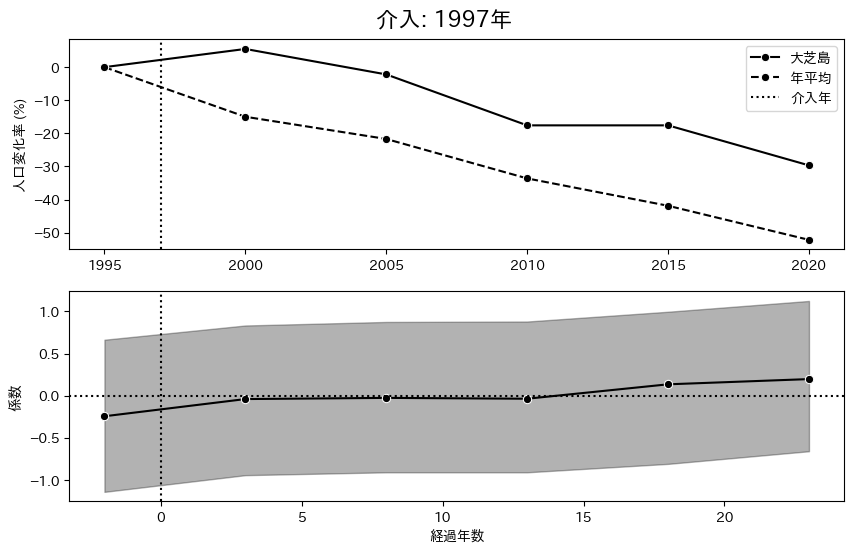

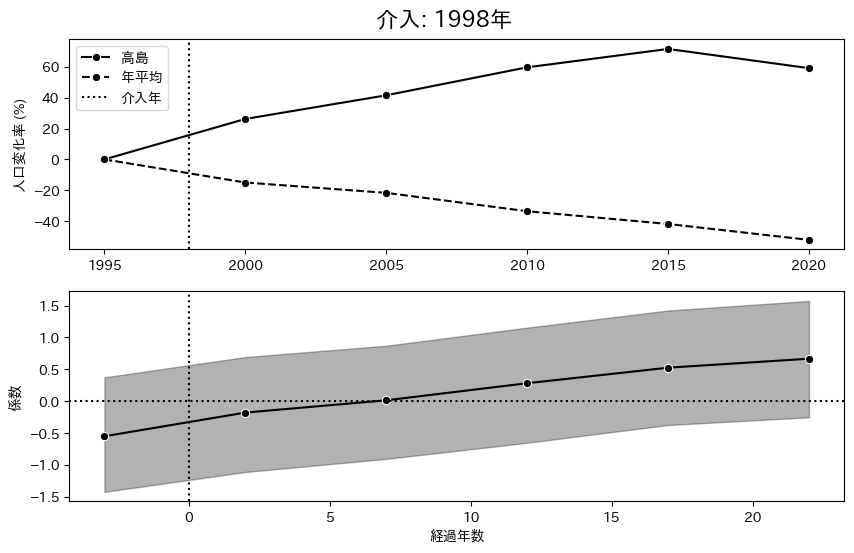

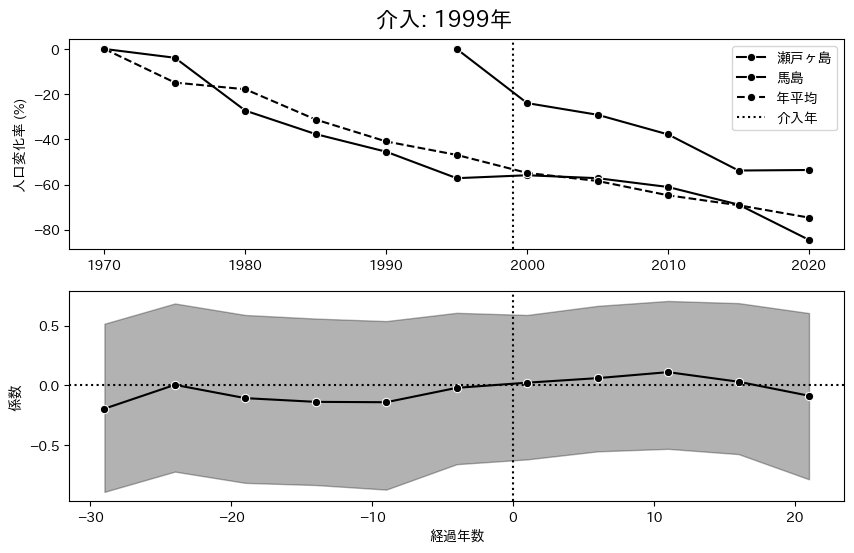

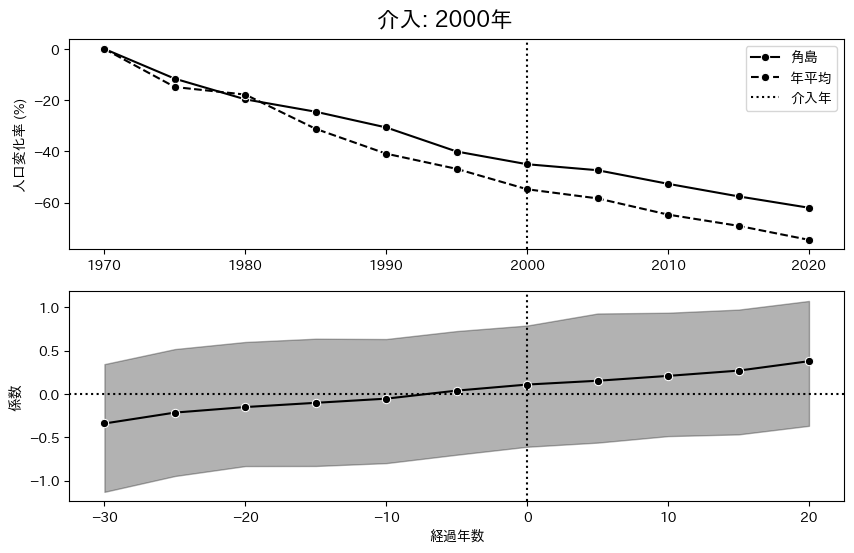

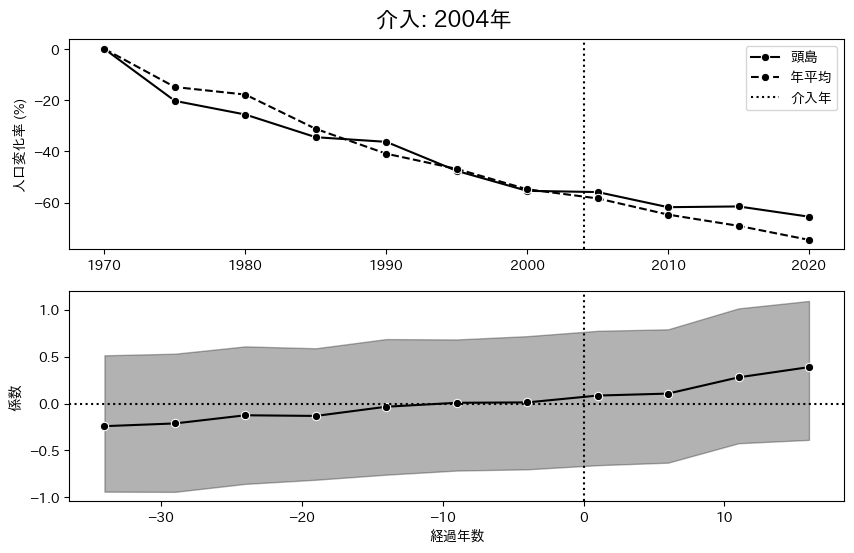

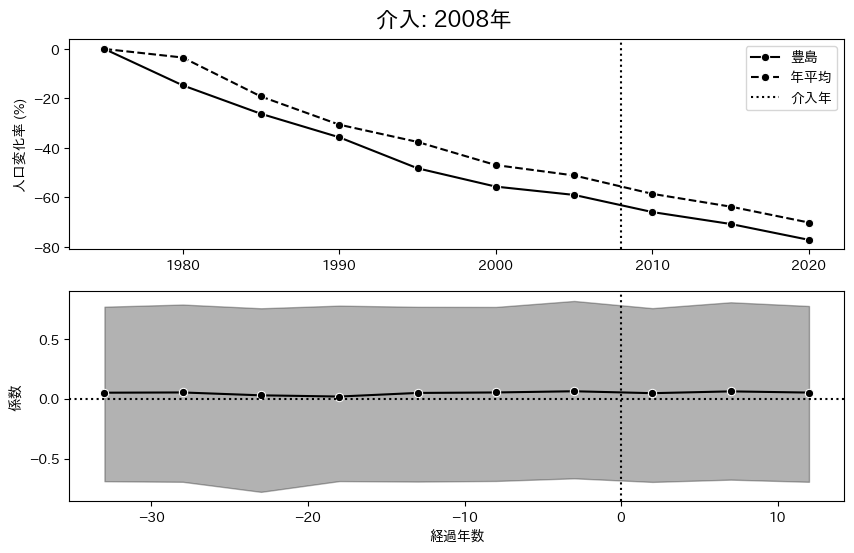

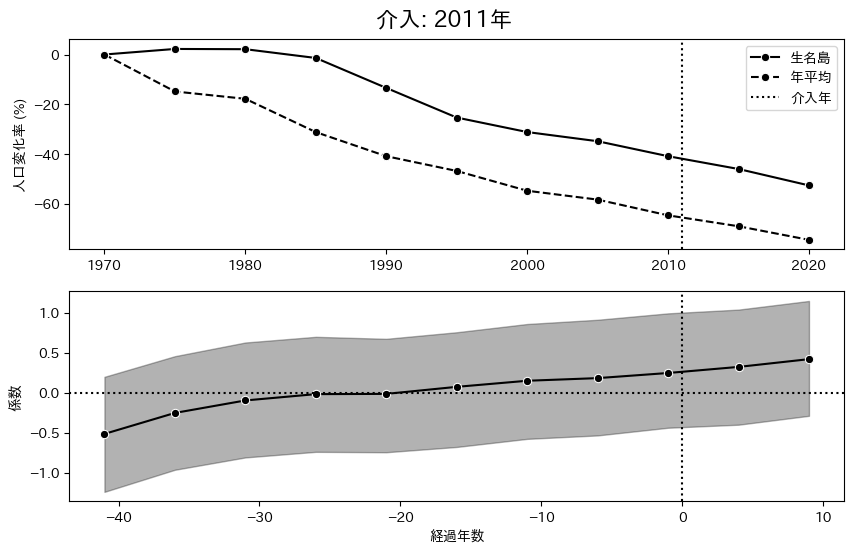

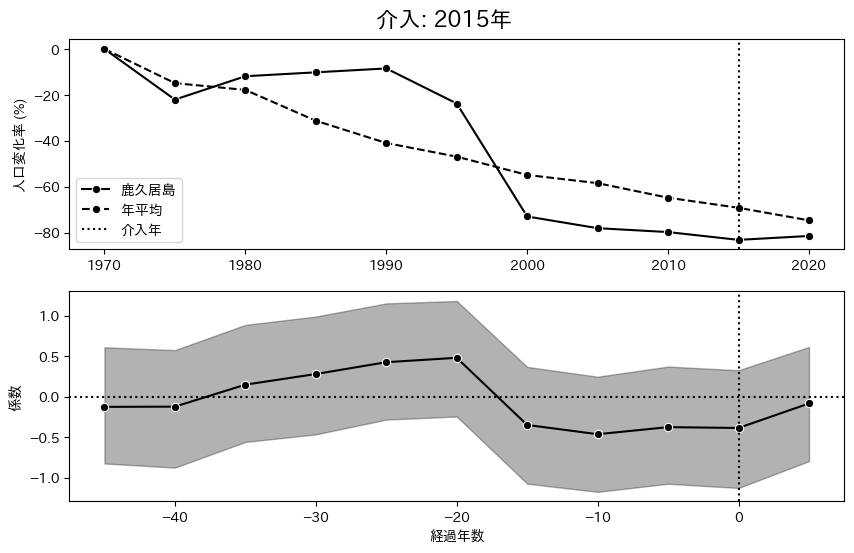

In [124]:
for bridge_year in bridge_year_list:
    beta_homo.plot_population_and_treatment_effect(bridge_year=bridge_year)

/tmp/ipykernel_18995/2652636130.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df['year_mean_diff'] = year_df.year_mean.diff()
/tmp/ipykernel_18995/2652636130.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df.fillna(0, inplace=True)
/tmp/ipykernel_18995/2652636130.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

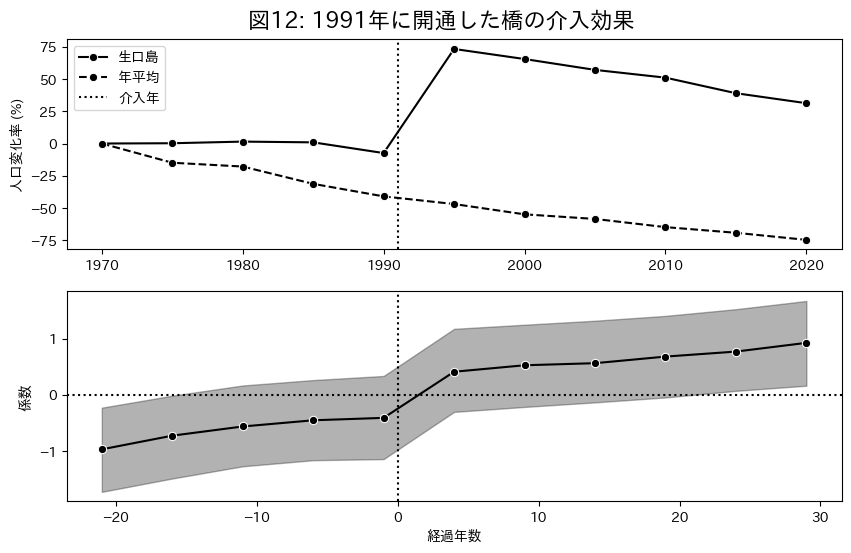

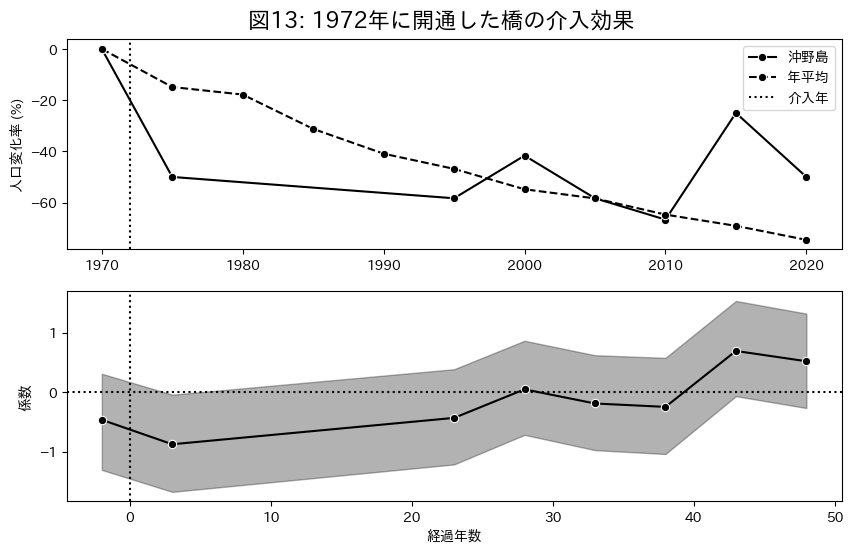

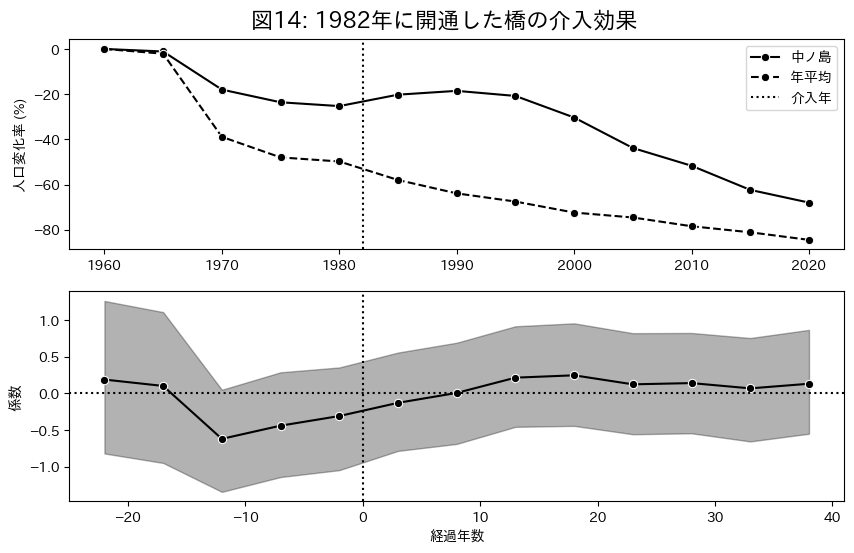

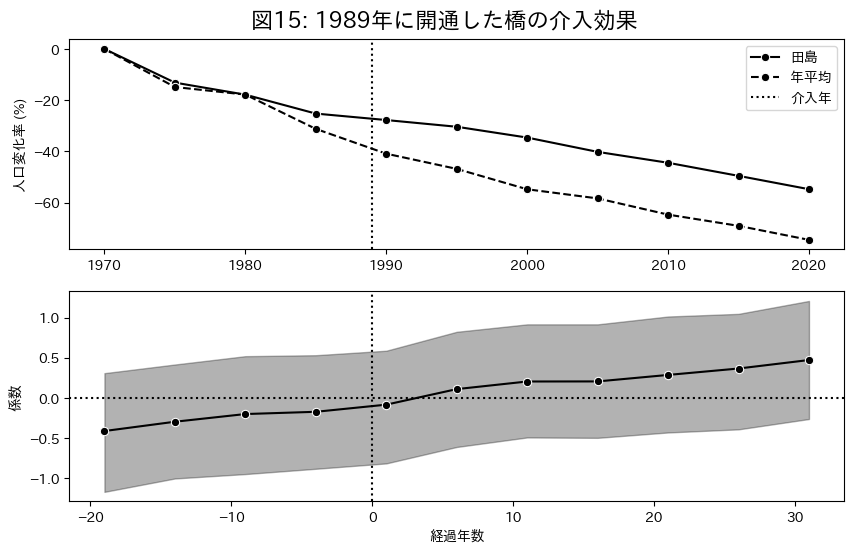

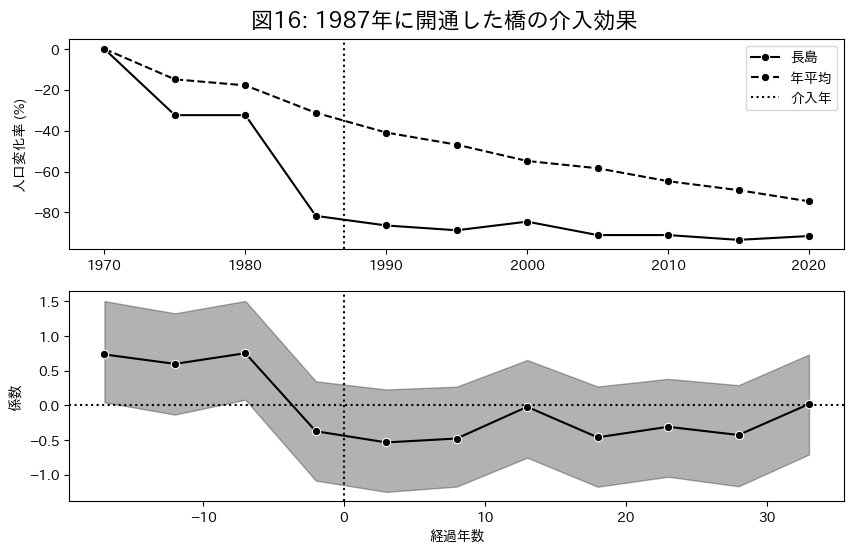

In [9]:
bridge_year_list = [1991, 1972, 1982, 1989, 1987]
fig_num_list = [12, 13, 14, 15, 16]
for i in range(len(bridge_year_list)):
    beta_homo.plot_population_and_treatment_effect(bridge_year=bridge_year_list[i], fig_num=fig_num_list[i])

In [118]:
bridge_year_list_same_as_year_mean = [1975, 1992, 1995, 2000, 2008]
for bridge_year in bridge_year_list_same_as_year_mean:
    beta_homo.plot_population_and_treatment_effect(bridge_year=bridge_year)

NameError: name 'beta_homo' is not defined

## なぜ効果が島によって異なるのか

In [9]:
beta_df[['mean', 'time_since_treatment', 'bridge_year']]

,mean,time_since_treatment,bridge_year
0,0.510,-10,1970
1,0.402,-5,1970
2,-0.256,0,1970
3,0.020,5,1970
4,-0.045,10,1970
...,...,...,...
245,0.069,-16,2016
246,0.113,-11,2016
247,0.127,-6,2016
248,0.173,-1,2016


In [21]:
df.query('treatment_group == 1')[['island_ids', 'year', 'log_pop', 'time_since_treatment', 'bridge_year', 'area_km2', 'distance_m']]

,island_ids,year,log_pop,time_since_treatment,bridge_year,area_km2,distance_m
0,67,1995,6.054439,-4,1999,0.28,615.0
1,67,2000,5.780744,1,1999,0.28,615.0
2,67,2005,5.710427,6,1999,0.28,615.0
3,67,2010,5.579730,11,1999,0.28,615.0
4,67,2015,5.283204,16,1999,0.28,615.0
...,...,...,...,...,...,...,...
789,223,2000,6.658011,24,1976,1.01,60.0
790,223,2005,6.520621,29,1976,1.01,60.0
791,223,2010,6.354370,34,1976,1.01,60.0
792,223,2015,6.190315,39,1976,1.01,60.0


In [24]:
# 2つのデータフレームを結合
merged_df = pd.merge(df.query('treatment_group == 1'), beta_df, on=['bridge_year', 'time_since_treatment'])

merged_df

,island_names,year,island_ids,region_codes,region_names,prefecture_codes,population,treatment_group,treatment_group_mainland,bridge_year,...,Unnamed: 0,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,瀬戸ヶ島,1995,67,32202,浜田市,32,426,1,1,1999,...,beta[C(bridge_year)[1999]:C(time_since_treatme...,-0.020,0.326,-0.657,0.606,0.005,0.003,4785.0,5753.0,1.0
1,瀬戸ヶ島,2000,67,32202,浜田市,32,324,1,1,1999,...,beta[C(bridge_year)[1999]:C(time_since_treatme...,0.023,0.312,-0.617,0.588,0.005,0.003,4655.0,5205.0,1.0
2,瀬戸ヶ島,2005,67,32202,浜田市,32,302,1,1,1999,...,beta[C(bridge_year)[1999]:C(time_since_treatme...,0.061,0.316,-0.550,0.664,0.005,0.003,4694.0,5335.0,1.0
3,瀬戸ヶ島,2010,67,32202,浜田市,32,265,1,1,1999,...,beta[C(bridge_year)[1999]:C(time_since_treatme...,0.111,0.317,-0.529,0.705,0.005,0.003,4628.0,5351.0,1.0
4,瀬戸ヶ島,2015,67,32202,浜田市,32,197,1,1,1999,...,beta[C(bridge_year)[1999]:C(time_since_treatme...,0.031,0.321,-0.573,0.687,0.005,0.003,4904.0,5631.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,大島,2000,223,39208,宿毛市,39,779,1,1,1976,...,beta[C(bridge_year)[1976]:C(time_since_treatme...,0.243,0.300,-0.328,0.849,0.005,0.003,4362.0,5091.0,1.0
338,大島,2005,223,39208,宿毛市,39,679,1,1,1976,...,beta[C(bridge_year)[1976]:C(time_since_treatme...,0.239,0.299,-0.353,0.823,0.005,0.003,4300.0,5193.0,1.0
339,大島,2010,223,39208,宿毛市,39,575,1,1,1976,...,beta[C(bridge_year)[1976]:C(time_since_treatme...,0.264,0.299,-0.290,0.870,0.005,0.003,4219.0,5074.0,1.0
340,大島,2015,223,39208,宿毛市,39,488,1,1,1976,...,beta[C(bridge_year)[1976]:C(time_since_treatme...,0.305,0.299,-0.246,0.931,0.005,0.003,4018.0,5417.0,1.0


In [31]:
merged_df['log_area'] = np.log(merged_df['area_km2'])

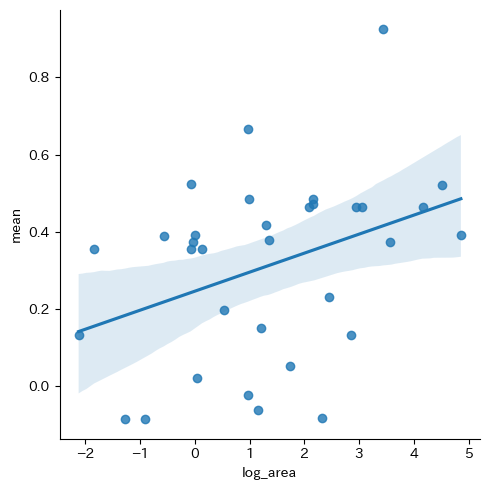

In [76]:
# fig, ax = plt.subplots(figsize=figsize)
sns.lmplot(data=merged_df.query('year == 2020'), x='log_area', y='mean')

In [93]:
formula = 'mean ~ log_area + distance_m'
y, X = dmatrices(formula, merged_df.query('year == 2020'), return_type='dataframe')
model = sm.OLS(y, X)
result = model.fit(cov_type='HC3')
y_pred = result.predict(X)
residuals = result.resid
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     3.013
Date:                Wed, 15 Jan 2025   Prob (F-statistic):             0.0642
Time:                        13:51:41   Log-Likelihood:                 3.6578
No. Observations:                  33   AIC:                            -1.316
Df Residuals:                      30   BIC:                             3.174
Df Model:                           2                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2707      0.078      3.453      0.001       0.117       0.424
log_area       0.0497      0.020      2.450      0.014       0.010       0.090
distance_m -4.622e-05      0.000     -0.430      0.667      -0.000       0.000
==============================================================================
Omnibus:                        0.163   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.922   Jarque-Bera (JB):                0.344
Skew:                          -0.124   Prob(JB):                        0.842
Kurtosis:                       2.565   Cond. No.                     1.31e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

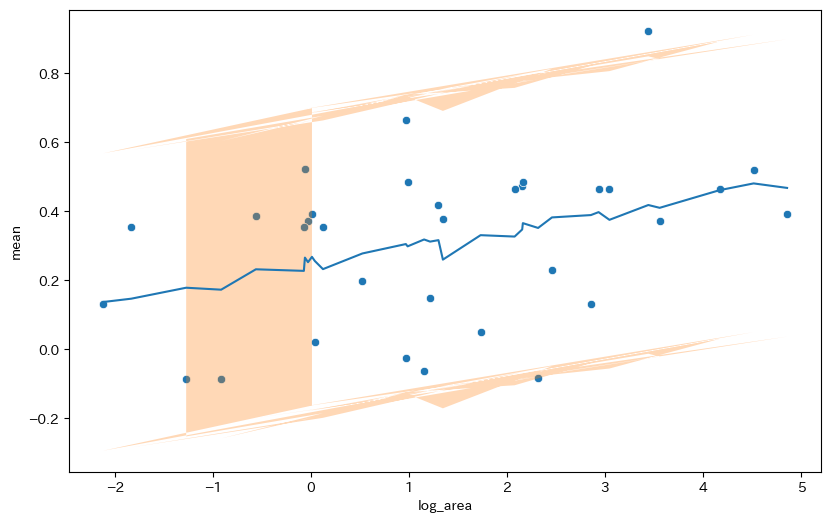

In [95]:
fig, ax = plt.subplots(figsize=figsize)
sns.scatterplot(data=merged_df.query('year == 2020'), x='log_area', y='mean')
sns.lineplot(data=merged_df.query('year == 2020'), x='log_area', y=y_pred)
ax.fill_between(
    merged_df.query('year == 2020')['log_area'],
    y_pred - 1.96 * residuals.std(),
    y_pred + 1.96 * residuals.std(),
    alpha=0.3
)

In [6]:
df_g = beta_df.query(f'bridge_year == {bridge_year}')
df_g

,Unnamed: 0,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,bridge_year,time_since_treatment
39,beta[C(bridge_year)[1976]:C(time_since_treatme...,0.295,0.543,-0.743,1.382,0.007,0.006,6989.0,5047.0,1.0,1976,-16
40,beta[C(bridge_year)[1976]:C(time_since_treatme...,0.208,0.521,-0.794,1.267,0.006,0.006,7340.0,5520.0,1.0,1976,-11
41,beta[C(bridge_year)[1976]:C(time_since_treatme...,-0.420,0.299,-0.993,0.162,0.005,0.003,4305.0,5535.0,1.0,1976,-6
42,beta[C(bridge_year)[1976]:C(time_since_treatme...,-0.203,0.298,-0.797,0.361,0.004,0.003,4463.0,5280.0,1.0,1976,-1
43,beta[C(bridge_year)[1976]:C(time_since_treatme...,-0.105,0.301,-0.695,0.479,0.005,0.003,4399.0,5235.0,1.0,1976,4
44,beta[C(bridge_year)[1976]:C(time_since_treatme...,-0.044,0.300,-0.599,0.567,0.005,0.003,4220.0,5055.0,1.0,1976,9
45,beta[C(bridge_year)[1976]:C(time_since_treatme...,-0.000,0.298,-0.584,0.586,0.004,0.003,4442.0,5081.0,1.0,1976,14
46,beta[C(bridge_year)[1976]:C(time_since_treatme...,0.154,0.301,-0.449,0.741,0.005,0.003,4422.0,5311.0,1.0,1976,19
47,beta[C(bridge_year)[1976]:C(time_since_treatme...,0.243,0.300,-0.328,0.849,0.005,0.003,4362.0,5091.0,1.0,1976,24
48,beta[C(bridge_year)[1976]:C(time_since_treatme...,0.239,0.299,-0.353,0.823,0.005,0.003,4300.0,5193.0,1.0,1976,29


## 屋代島 (周防大島)

In [ ]:
df_yashiro_shodo = df_yashiro_shodo.dropna(subset=['population'])
df_yashiro_shodo['log_pop'] = np.log(df_yashiro_shodo['population'])
df_yashiro_shodo['log_pop_diff'] = df_yashiro_shodo.groupby('island_ids')['log_pop'].diff()
df_yashiro_shodo['log_pop_diff'] = df_yashiro_shodo.groupby('island_ids')['log_pop_diff'].fillna(0)
df_yashiro_shodo['log_pop_diff_rate'] = df_yashiro_shodo.groupby('island_ids')['log_pop_diff'].cumsum()
df_yashiro_shodo['pop_rate_of_change'] = 100 * (np.exp(df_yashiro_shodo['log_pop_diff_rate']) - 1)

/tmp/ipykernel_86691/2568875776.py:4: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df_yashiro_shodo['log_pop_diff'] = df_yashiro_shodo.groupby('island_ids')['log_pop_diff'].fillna(0)


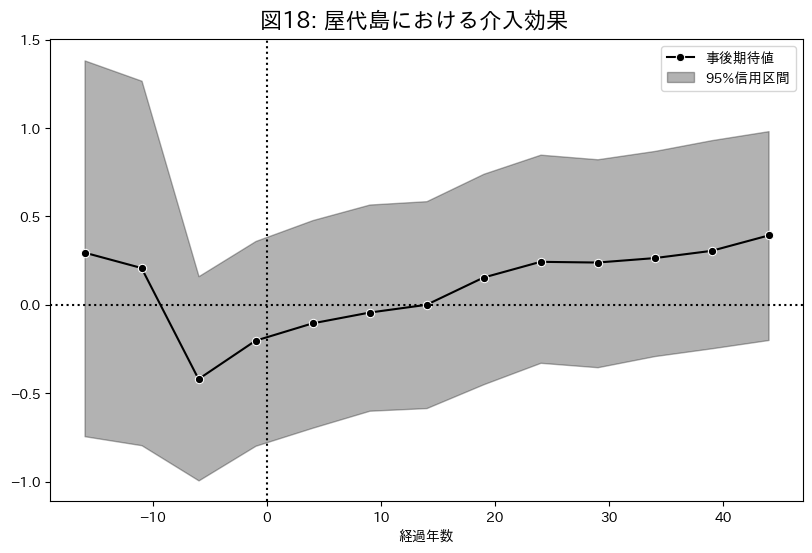

In [18]:
island_names = '屋代島'
bridge_year = 1976

fig, ax = plt.subplots(figsize=figsize)
fig.suptitle(f'図18: 屋代島における介入効果', fontsize=16, y=0.93)
# 係数のプロット
beta_g = beta_df.query(f'bridge_year == {bridge_year}').sort_values('time_since_treatment')
sns.lineplot(
    data=beta_g,
    x='time_since_treatment',
    y='mean',
    color='black',
    marker='o',
    label='事後期待値',
    ax=ax
)
ax.fill_between(
    x='time_since_treatment',
    y1='hdi_97.5%',
    y2='hdi_2.5%',
    data=beta_g,
    alpha=0.3,
    color='black',
    label='95%信用区間'
)
ax.axhline(0, color='black', ls=':')
ax.axvline(0, color='black', ls=':')
ax.set_xlabel('経過年数')
ax.set_ylabel('')
ax.legend()

filepath = f'../../docs/figures/fully_saturated_twfe/yashiro.png'
fig.savefig(filepath, bbox_inches='tight')

In [5]:
df_yashiro_shodo

,island_names,year,island_ids,region_codes,region_names,prefecture_codes,population,treatment_group,treatment_group_mainland,bridge_year,after_treatment,connect_mainland_year,after_treatment_mainland,prefecture_names,area_km2,distance_m,log_pop,log_pop_diff,log_pop_diff_rate,pop_rate_of_change
0,屋代島,1970,125,35302,（旧）大島町,35,35760,1,1,1976,0,1976,0,山口県,128.48,950,10.484585,0.000000,0.000000,0.000000
1,屋代島,1975,125,35302,（旧）大島町,35,32870,1,1,1976,0,1976,0,山口県,128.48,950,10.400316,-0.084270,-0.084270,-8.081655
2,屋代島,1980,125,35302,（旧）大島町,35,30810,1,1,1976,1,1976,1,山口県,128.48,950,10.335595,-0.064721,-0.148991,-13.842282
3,屋代島,1985,125,35302,（旧）大島町,35,29057,1,1,1976,1,1976,1,山口県,128.48,950,10.277015,-0.058580,-0.207571,-18.744407
4,屋代島,1990,125,35302,（旧）大島町,35,26503,1,1,1976,1,1976,1,山口県,128.48,950,10.185013,-0.092001,-0.299572,-25.886465
5,屋代島,1995,125,35302,（旧）大島町,35,24039,1,1,1976,1,1976,1,山口県,128.48,950,10.087433,-0.097580,-0.397152,-32.776846
6,屋代島,2000,125,35302,（旧）大島町,35,21796,1,1,1976,1,1976,1,山口県,128.48,950,9.989482,-0.097951,-0.495103,-39.049217
7,屋代島,2005,125,35305,周防大島町,35,20813,1,1,1976,1,1976,1,山口県,128.48,950,9.943333,-0.046149,-0.541252,-41.798098
8,屋代島,2010,125,35305,周防大島町,35,18589,1,1,1976,1,1976,1,山口県,128.48,950,9.830325,-0.113008,-0.654260,-48.017338
9,屋代島,2015,125,35305,周防大島町,35,16766,1,1,1976,1,1976,1,山口県,128.48,950,9.727108,-0.103217,-0.757477,-53.115213


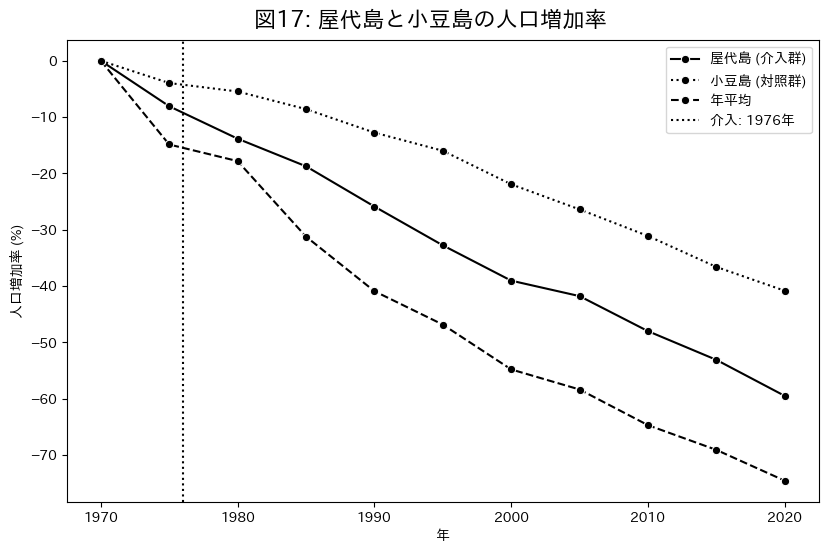

In [19]:
fig, ax = plt.subplots(figsize=(1.618*6, 1*6))
fig.suptitle('図17: 屋代島と小豆島の人口増加率', fontsize=16, y=0.93)
# 人口増加率のプロット
sns.lineplot(
    x='year',
    y='pop_rate_of_change',
    data=df_yashiro_shodo.query('island_names == "屋代島"'),
    color='black',
    marker='o',
    ax=ax,
    label='屋代島 (介入群)'
)
sns.lineplot(
    x='year',
    y='pop_rate_of_change',
    data=df_yashiro_shodo.query('island_names == "小豆島"'),
    color='black',
    marker='o',
    ax=ax,
    label='小豆島 (対照群)',
    ls=':'
)
# 年平均のプロット
year_df = pd.DataFrame()
year_df['year_mean'] = df.groupby('year')['log_pop'].mean()
min_year = df_yashiro_shodo.year.min()
year_df = year_df.query(f'year >= {min_year}')
year_df['year_mean_diff'] = year_df.year_mean.diff()
year_df.fillna(0, inplace=True)
year_df['year_mean_cumsum'] = year_df['year_mean_diff'].cumsum()
year_df['year_mean_change_rate'] = 100 * (np.exp(year_df['year_mean_cumsum']) - 1)
sns.lineplot(data=year_df, x=year_df.index, y='year_mean_change_rate', ax=ax, color='black', marker='o', label='年平均', ls='--')
ax.axvline(bridge_year, color='black', ls=':', label=f'介入: {bridge_year}年')
ax.set_ylabel('人口増加率 (%)')
ax.set_xlabel('年')
ax.legend()
plt.savefig('../../docs/figures/fully_saturated_twfe/yashiro_shodo.png', bbox_inches='tight')

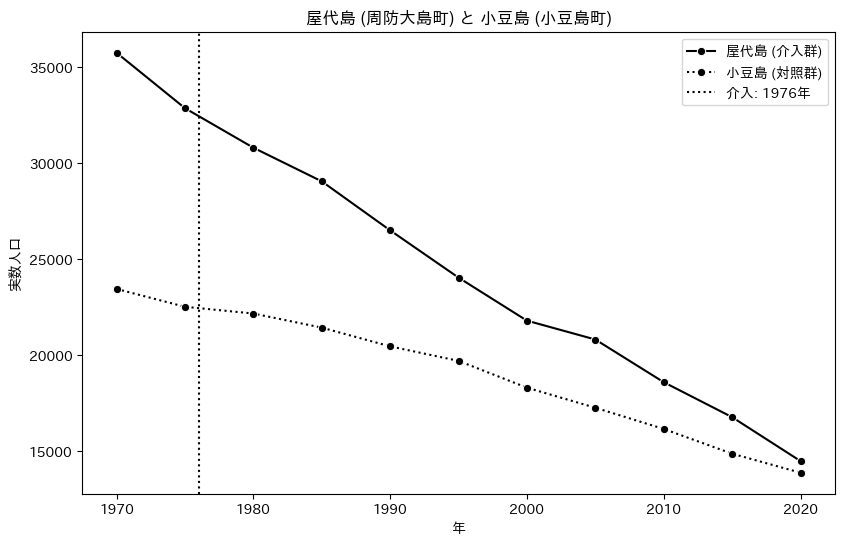

In [7]:
bridge_year = 1976

fig, ax = plt.subplots(figsize=(1.618*6, 1*6))
# 人口変化率のプロット
sns.lineplot(
    x='year',
    y='population',
    data=df_yashiro_shodo.query('island_names == "屋代島"'),
    color='black',
    marker='o',
    ax=ax,
    label='屋代島 (介入群)'
)
sns.lineplot(
    x='year',
    y='population',
    data=df_yashiro_shodo.query('island_names == "小豆島"'),
    color='black',
    marker='o',
    ax=ax,
    label='小豆島 (対照群)',
    ls=':'
)
ax.axvline(bridge_year, color='black', ls=':', label=f'介入: {bridge_year}年')
ax.set_title('屋代島 (周防大島町) と 小豆島 (小豆島町)')
ax.set_ylabel('実数人口')
ax.set_xlabel('年')
ax.legend()
plt.savefig('../../docs/figures/fully_saturated_twfe/yashiro_shodo_real.png', bbox_inches='tight')

In [8]:
year_df

,year_mean,year_mean_diff,year_mean_cumsum,year_mean_change_rate
year,,,,
1970,6.370601,0.000000,0.000000,0.000000
1975,6.209552,-0.161049,-0.161049,-14.874962
1980,6.174318,-0.035234,-0.196283,-17.822059
1985,5.996276,-0.178042,-0.374325,-31.224652
1990,5.844400,-0.151876,-0.526201,-40.915449
1995,5.738550,-0.105850,-0.632051,-46.849933
2000,5.576233,-0.162317,-0.794368,-54.813333
2005,5.494012,-0.082221,-0.876589,-58.379989
2010,5.328979,-0.165033,-1.041622,-64.711826
